In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import math
import numpy as np
import pandas as pd
import networkx as nx
import igraph as ig
import scipy.sparse as sparse
import json
import os

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as plt

import seaborn as sns

sns.set_style("white")

from bundling3D import *

The main function is hammer_bundle
it requires 2 input DataFrames:

1. node positions where the index of the DataFrame is the node id, and it contains the columns 'x', 'y', 'z'
2. edge list where each edge is an undirected link from 'source' to 'target'


In [12]:
p = "/Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/intermediate_graph_bundled_clusters0to100.graphml"
g = ig.Graph.Read_GraphML(p)

In [14]:
nodes_data = {attr: g.vs[attr] for attr in g.vs.attributes()}
nodes_df = pd.DataFrame(nodes_data)
nodes_df["node_ind"] = [n.index for n in g.vs]
# drop title, doi, none_name
nodes_df = nodes_df.drop(columns=["_nx_name", "title", "doi", "node_name"])


# Calculate min/max for coordinates
xmin, xmax = np.min(nodes_df["x"]), np.max(nodes_df["x"])
ymin, ymax = np.min(nodes_df["y"]), np.max(nodes_df["y"])
zmin, zmax = np.min(nodes_df["z"]), np.max(nodes_df["z"])

print(f"Min x: {xmin}, Max x: {xmax}")
print(f"Min y: {ymin}, Max y: {ymax}")
print(f"Min z: {zmin}, Max z: {zmax}")

nodes_df.head(3)

Min x: -1.0, Max x: 0.746563196182251
Min y: -0.753902673721313, Max y: 0.770878851413727
Min z: -0.15, Max z: 0.15


,year,cluster,node_id,centrality,x,y,z,id,node_ind
0,1982.0,70.0,0.0,0.045627,-0.092179,0.493333,-0.136321,n0,0
1,1982.0,65.0,1.0,0.010706,0.122104,0.376665,-0.146798,n1,1
2,1982.0,41.0,2.0,0.039863,0.462303,-0.097139,-0.138051,n2,2


In [15]:
# Create DataFrame for edges
edges_data = {attr: g.es[attr] for attr in g.es.attributes()}
edges_data = {attr: g.es[attr] for attr in g.es.attributes()}
edges_data["source"] = [e.source for e in g.es]
edges_data["target"] = [e.target for e in g.es]
edges_df = pd.DataFrame(edges_data)
edges_df.head(3)

,edge_id,weight,source,target
0,18.0,0.661442,1,3
1,20.0,0.660123,1,722
2,50.0,0.663864,2,4


In [16]:
df_pos = pd.merge(
    edges_df, nodes_df[["x", "y", "z"]], left_on="source", right_index=True
)
df_pos = df_pos.rename(columns={"x": "x_src", "y": "y_src", "z": "z_src"})

df_pos = pd.merge(df_pos, nodes_df[["x", "y", "z"]], left_on="target", right_index=True)
df_pos = df_pos.rename(columns={"x": "x_tgt", "y": "y_tgt", "z": "z_tgt"})

print(df_pos.shape)

df_pos.dropna(inplace=True)


df_pos = df_pos.sort_index()
df_pos = df_pos.reset_index()
print(df_pos.shape)

df_pos.head(2)

(112849, 10)
(112849, 11)


,index,edge_id,weight,source,target,x_src,y_src,z_src,x_tgt,y_tgt,z_tgt
0,0,18.0,0.661442,1,3,0.122104,0.376665,-0.146798,0.188209,0.276197,-0.106892
1,1,20.0,0.660123,1,722,0.122104,0.376665,-0.146798,0.151891,0.451476,-0.137293


In [17]:
df_pos["segment_length"] = [
    distance_between(x[:3], x[3:])
    for x in df_pos[["x_src", "y_src", "z_src", "x_tgt", "y_tgt", "z_tgt"]].values
]
df_pos = df_pos[df_pos["segment_length"] > 0]
print(df_pos.shape)

df_pos[["source", "target"]] = (
    df_pos[["source", "target"]].stack().rank(method="dense").unstack().astype(int)
)

print(f"Min segment length: {df_pos['segment_length'].min()}")
print(f"Max segment length: {df_pos['segment_length'].max()}")
print(f"Mean segment length: {df_pos['segment_length'].mean()}")
# median
print(f"Median segment length: {df_pos['segment_length'].median()}")
df_pos.head(2)

(112849, 12)
Min segment length: 4.452323537975912e-05
Max segment length: 0.6174757155148819
Mean segment length: 0.12388325568819092
Median segment length: 0.11190535055058408


,index,edge_id,weight,source,target,x_src,y_src,z_src,x_tgt,y_tgt,z_tgt,segment_length
0,0,18.0,0.661442,1,3,0.122104,0.376665,-0.146798,0.188209,0.276197,-0.106892,0.126713
1,1,20.0,0.660123,1,488,0.122104,0.376665,-0.146798,0.151891,0.451476,-0.137293,0.081082


In [18]:
comb_set = set(df_pos["source"].unique()).union(set(df_pos["target"].unique()))

df_pos["source"].unique().shape, df_pos["target"].unique().shape, nodes_df.shape, len(
    comb_set
)

((25094,), (27196,), (37804, 9), 32497)

In [20]:
Nnodes = nodes_df.shape[0]
print(f"Number of nodes: {Nnodes}")
subedges = df_pos["segment_length"] > df_pos["segment_length"].median()
subedges.sum()


mat = sparse.coo_matrix(
    (
        np.ones(df_pos.loc[subedges].shape[0], dtype=int),
        (
            df_pos.loc[subedges, "source"].values,
            df_pos.loc[subedges, "target"].values,
        ),
    ),
    shape=(Nnodes, Nnodes),
)
print(mat.shape)

Number of nodes: 37804
(37804, 37804)


In [23]:
ncomp, membership = sparse.csgraph.connected_components(mat)

mvalue, mcounts = np.unique(membership, return_counts=True)
mcounts, mcountdist = np.unique(mcounts, return_counts=True)

mcounts, mcountdist

(array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
           10,    11,    12,    13,    15,    16,    17,    18,    19,
           20,    23,    29, 23147]),
 array([10709,   896,   249,   108,    43,    28,    13,     6,     7,
            7,     3,     1,     1,     1,     3,     1,     3,     2,
            2,     1,     1,     1]))

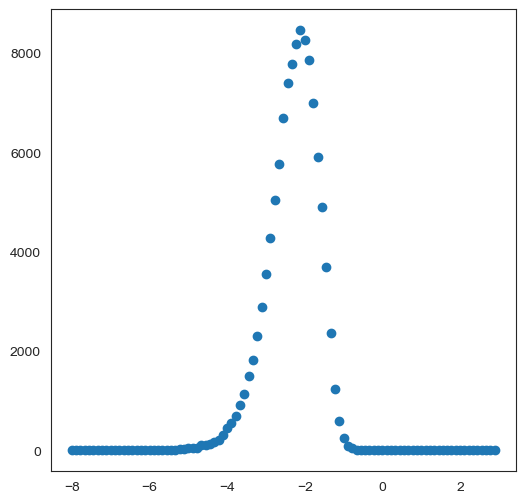

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

dist, bins = np.histogram(
    df_pos["segment_length"].values, bins=np.exp(np.linspace(-8, 3, 100))
)

ax.scatter(np.log(bins[:-1]), dist)

plt.show()

In [25]:
print("Nr of Nodes: ", Nnodes)
print("Nr of Edges: ", df_pos.shape[0])

Nr of Nodes:  37804
Nr of Edges:  112849


In [26]:
edges_df

,edge_id,weight,source,target
0,18.0,0.661442,1,3
1,20.0,0.660123,1,722
2,50.0,0.663864,2,4
3,64.0,0.810501,3,506
4,69.0,0.815381,3,840
...,...,...,...,...
112844,602774.0,0.682414,37750,37772
112845,602775.0,0.695086,37778,37800
112846,602776.0,0.815483,37778,37801
112847,602777.0,0.659758,37787,37792


In [30]:
cocite_bundled = hammer_bundle(
    nodes_df[["x", "y", "z"]],
    edges_df[["source", "target"]],
    initial_bandwidth=0.40,
    decay=0.7,
    accuracy=5 * 10**2,
    weight=None,
    advect_iterations=50,
    iterations=5,
    min_segment_length=0.001,
    max_segment_length=0.05,
)
cocite_bundled.head()

112849
Process Bundling
Start Bundling
Start Smoothing


,x,y,z
0,0.122104,0.376665,-0.146798
1,0.112285,0.372056,-0.142059
2,0.101397,0.366734,-0.137443
3,0.088696,0.360171,-0.133047
4,0.073740,0.351973,-0.128951


now the dataframe as all points of all edges. a new edge is signalled by a NaN row.


In [55]:
print(f"Nr of points: {cocite_bundled.shape[0]}")
print(bundled_edges.isna().sum()[0])
print(edges_df.shape[0])

Nr of points: 3864211
112849
112849


/var/folders/6m/zjbwrdgj0bg9zyhx3l7134mm0000gn/T/ipykernel_18397/1209578438.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(bundled_edges.isna().sum()[0])


In [42]:
bundled_edges = cocite_bundled.copy()
npts = bundled_edges.shape[0]
edges = edges_df.copy()
threshold = 0.05
ptnames = ["x_src", "y_src", "z_src", "x_tgt", "y_tgt", "z_tgt"]

bundled_edge_df = []
edgepts = []
iedge = 0
for irow in range(npts - 1):
    x = bundled_edges.loc[irow].values.flatten()

    if np.isnan(x).sum() > 0:

        path = "; ".join(map(str, edgepts))
        bundled_edge_df.append(
            [edges.loc[iedge, "source"], edges.loc[iedge, "target"], path]
        )

        iedge += 1
        edgepts = []

    else:
        edgepts.extend(list(x))
bundled_edge_df = pd.DataFrame(bundled_edge_df, columns=["source", "target", "path"])

In [64]:
# get those edges that are not bundled (smaller than threshold)
straight_edges = df_pos["segment_length"] <= threshold
straight_edge_df = df_pos[straight_edges]
print(f"Nr of straight edges: {straight_edge_df.shape[0]}")
straight_edge_df.head(2)

Nr of straight edges: 13605


,index,edge_id,weight,source,target,x_src,y_src,z_src,x_tgt,y_tgt,z_tgt,segment_length
11,11,233.0,0.661995,8,2162,-0.116112,0.501131,-0.141829,-0.137308,0.532768,-0.134901,0.038706
20,20,339.0,0.802072,12,228,0.137059,0.304343,-0.123482,0.112303,0.282483,-0.134452,0.034800


In [68]:
straight_edge_df["path"] = [
    "; ".join(map(str, row)) for row in straight_edge_df[ptnames].values
]
straight_edge_df = straight_edge_df[["source", "target", "path"]]

df_final = pd.concat([bundled_edge_df, straight_edge_df])

/var/folders/6m/zjbwrdgj0bg9zyhx3l7134mm0000gn/T/ipykernel_18397/3605132118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  straight_edge_df["path"] = [


In [69]:
df_final.head(2)

,source,target,path
0,1,3,0.12210372835397698; 0.3766651451587679; -0.14...
1,1,722,0.12210372835397698; 0.3766651451587679; -0.14...


In [ ]:
cociteedges.reset_index(drop=True, inplace=True)

In [ ]:
def bundle_between_clusters(nodes, edges, threshold=0.025):

    df = pd.merge(edges, nodes[["x", "y", "z"]], left_on=["source"], right_index=True)
    df = df.rename(columns={"x": "src_x", "y": "src_y", "z": "src_z"})

    df = pd.merge(df, nodes[["x", "y", "z"]], left_on=["target"], right_index=True)
    df = df.rename(columns={"x": "dst_x", "y": "dst_y", "z": "dst_z"})
    df.dropna(inplace=True)
    df = df.sort_index()
    df = df.reset_index()

    ptnames = ["src_x", "src_y", "src_z", "dst_x", "dst_y", "dst_z"]

    df["segment_length"] = [distance_between(x[:3], x[3:]) for x in df[ptnames].values]

    df = df[df["segment_length"] > 0]

    # df[['source', 'target']] = df[['source', 'target']].stack().rank(method='dense').unstack().astype(int)

    edges2bundle = df["segment_length"] > threshold

    bundled_edges = hammer_bundle(
        nodes[["x", "y", "z"]],
        df.loc[edges2bundle, ["source", "target"]],
        initial_bandwidth=0.40,
        decay=0.7,
        accuracy=5 * 10**2,
        weight=None,
        advect_iterations=50,
        iterations=5,
        min_segment_length=threshold / 2.0,
        max_segment_length=0.05,
    )

    npts = bundled_edges.shape[0]
    bundled_edge_df = []
    edgepts = []
    iedge = 0
    for irow in range(npts - 1):
        x = bundled_edges.loc[irow].values.flatten()

        if np.isnan(x).sum() > 0:

            path = "; ".join(map(str, edgepts))
            bundled_edge_df.append(
                [edges.loc[iedge, "source"], edges.loc[iedge, "target"], path]
            )

            iedge += 1
            edgepts = []

        else:
            edgepts.extend(list(x))
    bundled_edge_df = pd.DataFrame(
        bundled_edge_df, columns=["source", "target", "path"]
    )

    straight_edges = df["segment_length"] <= threshold
    straight_edge_df = df[straight_edges]
    straight_edge_df["path"] = [
        "; ".join(map(str, row)) for row in straight_edge_df[ptnames].values
    ]
    straight_edge_df = straight_edge_df[["source", "target", "path"]]

    return pd.concat([bundled_edge_df, straight_edge_df])


edgedf = bundle_between_clusters(nodes_df[["x", "y", "z"]], edges_df, threshold=0.025)

# edgedf.to_csv("/Users/ajgates/Desktop/cociteEdges2.csv", header=True, index=False)

AttributeError: 'DataFrame' object has no attribute 'get_values'

In [ ]:
edgedf.to_csv("/Users/ajgates/Desktop/cociteEdges2.csv", header=True, index=False)

In [ ]:
straight_edges = df["segment_length"] <= 0.025
straight_edge_df = df[straight_edges]
straight_edge_df["path"] = [
    "; ".join(map(str, row))
    for row in straight_edge_df[
        ["src_x", "src_y", "src_z", "dst_x", "dst_y", "dst_z"]
    ].values
]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
